# Facial Recognition using one-shot learning

Imports and global variables

In [1]:
import pandas as pd
import numpy as np
import os
import math
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import matplotlib.pyplot as plt

DIRECTORY = os.path.join("lfw2", "lfw2")
TRAIN_PATH = "pairsDevTrain.txt"
TEST_PATH = "pairsDevTest.txt"
IMG_SHAPE = (250, 250, 1)

Dataset and siamese network creation code

In [2]:
class MyDataset:
    def __init__(self, dir=None, ind=None):
        self.img_dir = dir
        # Creates the image filename/index dataframe
        temp = pd.read_csv(ind, sep="\t", names=["name1", "ind1", "name2", "ind2", "label"])
        temp.drop(0, axis=0, inplace=True)
        temp.index = range(len(temp))
        same = temp[temp["ind2"].isna()].copy()
        diff = temp[~temp["ind2"].isna()].copy()
        same["ind2"] = same["name2"]
        same["name2"] = same["name1"]
        same["label"] = 1
        diff["label"] = 0
        self.img_df = pd.concat([same, diff])
        self.img_df["ind1"] = self.img_df["ind1"].astype("int")
        self.img_df["ind2"] = self.img_df["ind2"].astype("int")
        self.img_df = self.img_df.sample(frac=1, random_state = 14).reset_index(drop=True)


    # Returns an (img1,img2,label) tuple, each image is in numpy array form
    def get_pair(self, index):
        img1_path = os.path.join(
            self.img_dir,
            self.img_df.iat[index, 0],
            str(self.img_df.iat[index, 0])
            + "_"
            + format(self.img_df.iat[index, 1], "04d")
            + ".jpg",
        )
        img2_path = os.path.join(
            self.img_dir,
            self.img_df.iat[index, 2],
            str(self.img_df.iat[index, 2])
            + "_"
            + format(self.img_df.iat[index, 3], "04d")
            + ".jpg",
        )
        return (
            np.asarray(Image.open(img1_path)),
            np.asarray(Image.open(img2_path)),
            self.img_df.iat[index, 4],
        )

    # Returns the images and labels as X and y
    def get_data(self, split=False):
        size = len(self.img_df)

        X = np.zeros((size, 2) + IMG_SHAPE)
        y = np.random.randint(0, 2, size=(size,))
        for i in range(size):
            pair = self.get_pair(i)
            img1 = pair[0].reshape(IMG_SHAPE)
            img2 = pair[1].reshape(IMG_SHAPE)
            X[i, 0] = img1
            X[i, 1] = img2
            y[i] = pair[2]

        if split:
            data = (
                X[0 : math.ceil(size * 0.8)],
                X[math.ceil(size * 0.8) :],
                y[0 : math.ceil(size * 0.8)],
                y[math.ceil(size * 0.8) :],
            )

        else:
            data = (X, y)

        return data


def create_siamese_network(input_shape):
    # Defines the model
    model = Sequential()
    model.add(Conv2D(64, (10, 10), activation="relu", input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (7, 7), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (4, 4), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, (4, 4), activation="relu"))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(4096, activation="sigmoid"))
    
    # Define the left and right input tensors
    left_input = Input(shape=input_shape)
    right_input = Input(shape=input_shape)

    # Connect the two identical CNNs
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Define the distance function
    L1_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Define the output layer
    prediction = Dense(1, activation="sigmoid")(L1_distance)

    # Define the siamese network
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

    lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=14,
    decay_rate=0.99)

    # Compile the siamese network
    optimizer = SGD(learning_rate=0.001, momentum=0.5)
    siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return siamese_net

The training function

In [3]:
# Trains the siamese network
def train_siamese_network(siamese_net, X_train, X_val, y_train, y_val, epochs, batch_size):
    callback = EarlyStopping(monitor="val_loss", patience=20)
    history = siamese_net.fit(
        [X_train[:, 0], X_train[:, 1]],
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=[[X_val[:, 0], X_val[:, 1]], y_val],
        callbacks=[callback],
    )
    return history

Evaluation and prediction

In [4]:
# Evaluates the siamese network
def evaluate_model(siamese_net, X_test, y_test, batch_size):
    results = siamese_net.evaluate([X_test[:, 0], X_test[:, 1]], y_test, batch_size=batch_size)
    return results

# Makes a one shot prediction on a pair of images
def one_shot_pred(siamese_net,X_test, y_test,pair_id):
    X = X_test[pair_id : pair_id+1]
    img1 = X[:, 0]
    img2 = X[:, 1]
    y = y_test[pair_id : pair_id+1]

    proba = siamese_net.predict([img1, img2])

    if y ==1:
        same = "same person"
    else:
        same = "different people"
    if np.argmax(proba) == y:
        correct = "Correct"
    else:
        correct = "Wrong"
    
    return([img1, img2],correct,same)

Plots and images

In [5]:
# Presents a pair of images
def show_pair(img1,img2):
    fig = plt.figure(figsize=(12,5))
    rows = 1
    columns = 2
    img1 = img1.reshape(IMG_SHAPE)
    img2 = img2.reshape(IMG_SHAPE)
    fig.add_subplot(rows,columns,1)
    plt.imshow(img1, cmap="gray",vmin=0,vmax=255)
    plt.axis('off')
    plt.title("Left")
    fig.add_subplot(rows,columns,2)
    plt.imshow(img2, cmap="gray",vmin=0,vmax=255)
    plt.axis('off')
    plt.title("Right")
    plt.show()

# Presents a plot of the loss and accuracy of the train and validation sets
def plot_results(history):
    train_acc = history.history["accuracy"]
    train_loss = history.history["loss"]
    val_acc = history.history["val_accuracy"]
    val_loss = history.history["val_loss"]

    plt.figure(figsize = (20,10))
    plt.subplot(1,2,1)
    plt.plot(train_acc,color="red",label="Train Accuracy")
    plt.plot(val_acc,color="blue",label="Validation Accuracy")
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.legend(loc = "upper left")
    plt.title('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(train_loss,color = 'red', label = 'Train Loss')
    plt.plot(val_loss,color = 'blue', label = 'Validation Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend(loc = "upper left")
    plt.title('Loss')
    plt.show()

Loading the dataset and creating the siamese network

In [6]:
train_data = MyDataset(DIRECTORY, TRAIN_PATH)
test_data = MyDataset(DIRECTORY, TEST_PATH)

# Creates the siamese network
siamese_net = create_siamese_network(IMG_SHAPE)

b_size = 128

X_train, X_val, y_train, y_val = train_data.get_data(split = True)

Training the network

Epoch 1/200
14/14 [==============================] - 503s 36s/step - loss: 0.7825 - accuracy: 0.4949 - val_loss: 0.6887 - val_accuracy: 0.5159
Epoch 2/200
14/14 [==============================] - 528s 38s/step - loss: 0.7366 - accuracy: 0.4915 - val_loss: 0.6921 - val_accuracy: 0.5182
Epoch 3/200
14/14 [==============================] - 529s 38s/step - loss: 0.7087 - accuracy: 0.5324 - val_loss: 0.7020 - val_accuracy: 0.5045
Epoch 4/200
14/14 [==============================] - 524s 37s/step - loss: 0.7141 - accuracy: 0.5330 - val_loss: 0.7019 - val_accuracy: 0.5182
Epoch 5/200
14/14 [==============================] - 523s 37s/step - loss: 0.6999 - accuracy: 0.5432 - val_loss: 0.6837 - val_accuracy: 0.5477
Epoch 6/200
14/14 [==============================] - 517s 37s/step - loss: 0.6971 - accuracy: 0.5426 - val_loss: 0.6863 - val_accuracy: 0.5250
Epoch 7/200
14/14 [==============================] - 517s 37s/step - loss: 0.6928 - accuracy: 0.5494 - val_loss: 0.6859 - val_accuracy: 0.5568

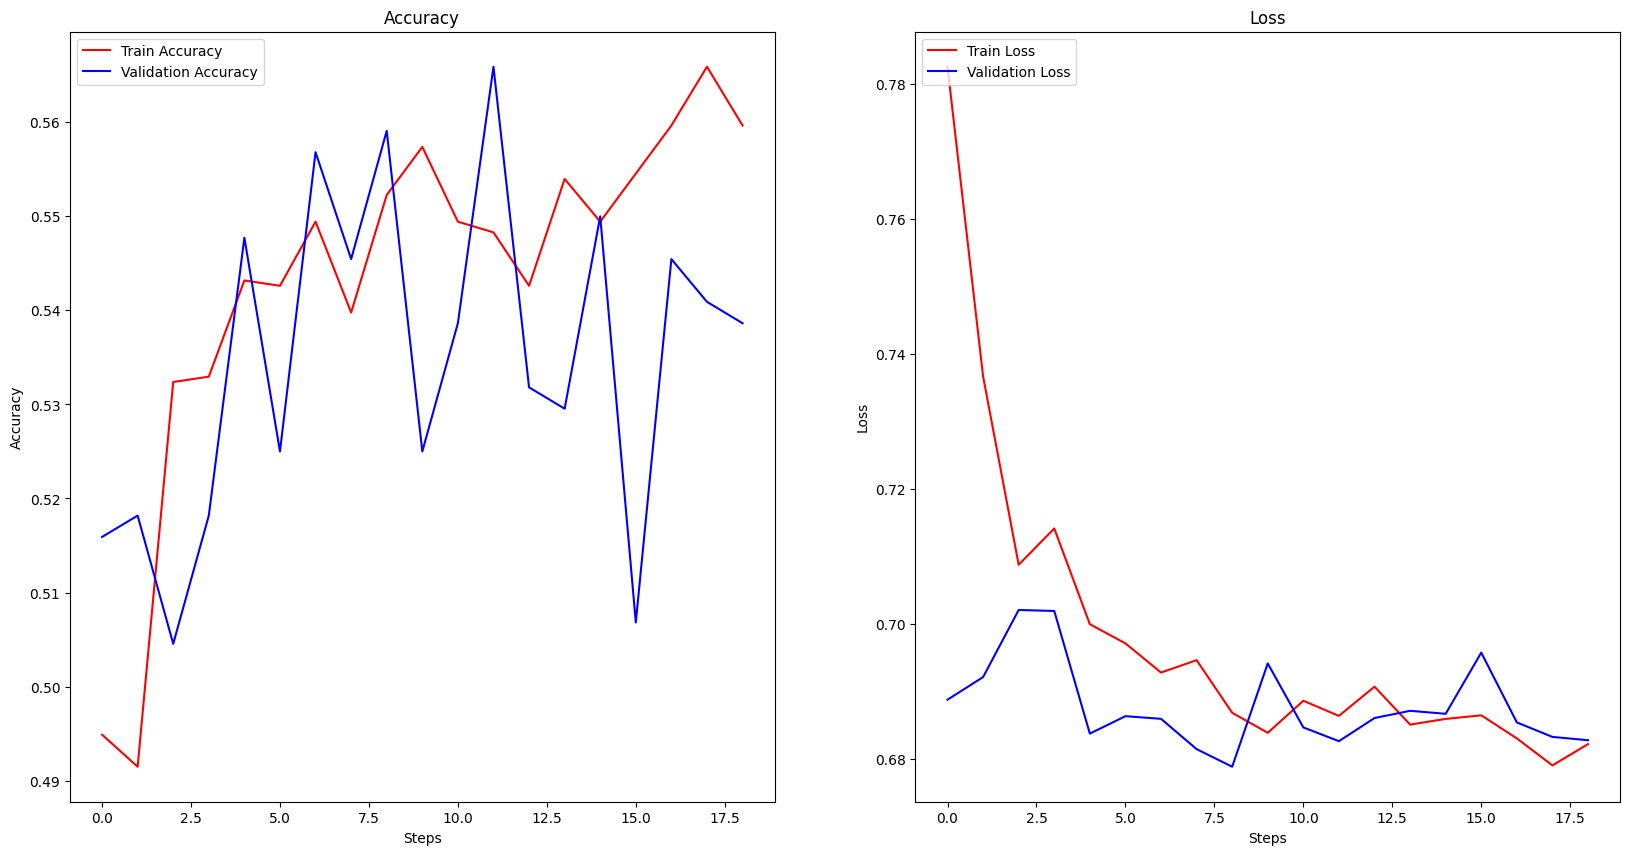

In [7]:
# Train the network and plot the results
hist = train_siamese_network(
    siamese_net, X_train, X_val, y_train, y_val, epochs=200, batch_size=b_size
)
print(f"{len(hist.history['loss'])} epochs until stopped")

plot_results(hist)

Running the evaluation and predictions

8/8 [==============================] - 62s 8s/step - loss: 0.6794 - accuracy: 0.5420
Evaluation results (loss, accuracy):  [0.6793989539146423, 0.5419999957084656]
1/1 [==============================] - 0s 315ms/step
Wrong prediction for images of same person: 


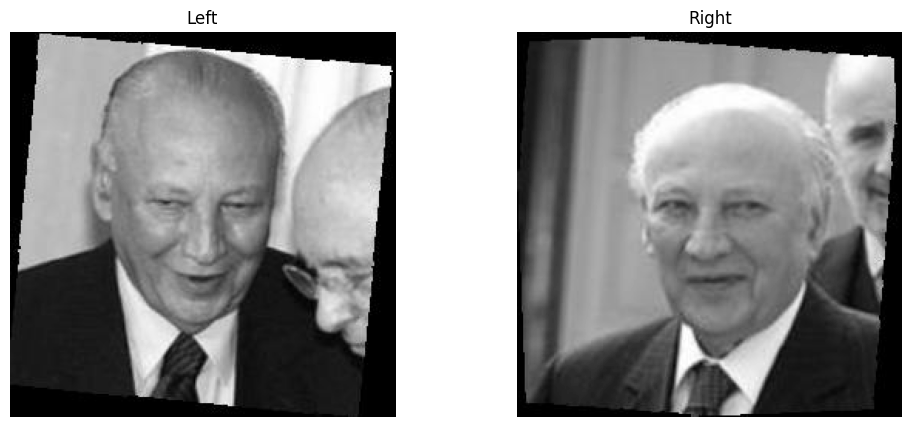

1/1 [==============================] - 0s 186ms/step
Correct prediction for images of different people: 


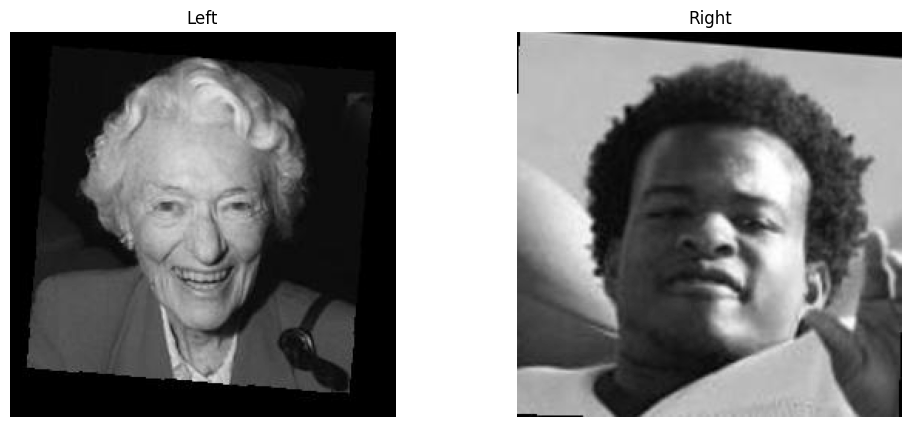

In [8]:
X_test, y_test = test_data.get_data()

# Evaluate the model
res = evaluate_model(siamese_net, X_test, y_test, batch_size=b_size)
print("Evaluation results (loss, accuracy): ",res)

# Test the prediction and print example images
need_correct = True
need_wrong = True
for i in range(100):
    if need_correct or need_wrong:
        [img1, img2], correct, same = one_shot_pred(siamese_net,X_test, y_test,i)
        if correct == "Correct" and need_correct:
            need_correct=False
            print(f"{correct} prediction for images of {same}: ")
            show_pair(img1, img2)
        elif correct == "Wrong" and need_wrong:
            need_wrong=False
            print(f"{correct} prediction for images of {same}: ")
            show_pair(img1, img2)
    else:
        break